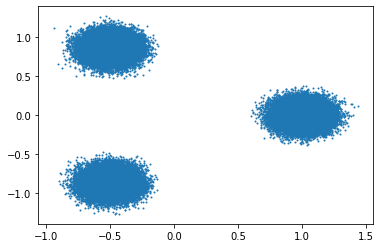

In [211]:
import torch
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


class CustomDataSet(torch.utils.data.Dataset):

    def __init__(self, n_group, n_data):

        self.n_group = n_group
        self.n_data = n_data
        _data = np.random.randn(self.n_data, 2)
        _label = np.ndarray(self.n_data, dtype=np.int)
        _mu = []
        _sig = 0.1
        for k in range(n_group):
            _mu.append([np.cos(2.0 * np.pi * k / n_group), np.sin(2.0 * np.pi * k / n_group)])
        for i in range(n_data):
            _data[i][0] = _sig * _data[i][0] + _mu[i % n_group][0]
            _data[i][1] = _sig * _data[i][1] + _mu[i % n_group][1]
            _label[i] = i % n_group

        self.data = torch.as_tensor(_data, dtype=torch.float32)
        self.label = torch.as_tensor(_label, dtype=torch.int64)

    def __len__(self):
        return self.n_data

    def __getitem__(self, idx):
        # return self.data[idx], self.label[idx]
        return self.data[idx]


data_size = 120000
dataset = CustomDataSet(n_group=3, n_data=data_size)

data_points = dataset.data.numpy()
plt.scatter(data_points[:, 0], data_points[:, 1], s=1)
plt.show()

In [0]:
mb_size = 64
Z_dim = 2
C_dim = 2
X_dim = 2

def Z(num_z=mb_size):
    return torch.randn(num_z, Z_dim)


def C(num_c=mb_size):
   return torch.randn(num_c, C_dim)


def negative_loglikelihood_loss(mu, sig, tar):
    loglikelihood = -torch.log(sig) - 0.5 * (np.log(2.0 *3.141592) + ((mu - tar)/sig)**2)
    return -loglikelihood.mean()


G = torch.nn.Sequential(
    torch.nn.Linear(Z_dim + C_dim, 16, bias=True),
    torch.nn.LeakyReLU(0.1),
    torch.nn.Linear(16, 16, bias=True),
    torch.nn.LeakyReLU(0.1),
    torch.nn.Linear(16, 16, bias=True),
    torch.nn.LeakyReLU(0.1),
    torch.nn.Linear(16, 16, bias=True),
    torch.nn.LeakyReLU(0.1),
    torch.nn.Linear(16, X_dim, bias=True))


D = torch.nn.Sequential(
    torch.nn.Linear(X_dim, 16, bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 16, bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 16, bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 1, bias=True),
    torch.nn.Sigmoid())


Q = torch.nn.Sequential(
    torch.nn.Linear(X_dim, 16, bias=True),
    torch.nn.LeakyReLU(0.1),
    torch.nn.Linear(16, 16, bias=True),
    torch.nn.LeakyReLU(0.1),
    torch.nn.Linear(16, 16, bias=True),
    torch.nn.LeakyReLU(0.1),
    torch.nn.Linear(16, 16, bias=True),
    torch.nn.LeakyReLU(0.1),
    torch.nn.Linear(16, C_dim, bias=True))

G_solver = optim.Adam(G.parameters(), lr=1e-3)
D_solver = optim.Adam(D.parameters(), lr=1e-3)
Q_solver = optim.Adam(Q.parameters(), lr=1e-3)

In [0]:
ones_label = torch.ones(mb_size, 1)
zeros_label = torch.zeros(mb_size, 1)
loader = DataLoader(dataset, batch_size=mb_size, shuffle=True, drop_last=True)
D_REAL = []
D_FAKE = []
MILBO = []

In [0]:
num_epochs = 50
for epoch in range(num_epochs):
    D_REAL_CUM = 0.0
    D_FAKE_CUM = 0.0
    MILBO_CUM = 0.0
    for _, X in enumerate(loader):

        D_solver.zero_grad()
        D_real = D(X)
        D_fake = D(G(torch.cat([Z(), C()], dim=1)))
        D_loss_real = nn.binary_cross_entropy(D_real, ones_label)
        D_loss_fake = nn.binary_cross_entropy(D_fake, zeros_label)
        (D_loss_real + D_loss_fake).backward()
        D_solver.step()
        
        Q_solver.zero_grad()
        G_solver.zero_grad()
        c = C()
        G_sample = G(torch.cat([Z(), c], dim=1))
        D_loss = nn.binary_cross_entropy(D(G_sample), ones_label)
        Q_loss = nn.mse_loss(Q(G_sample), c)
        (D_loss + Q_loss).backward()
        G_solver.step()
        Q_solver.step()
        D_REAL_CUM += D_real.mean().item()
        D_FAKE_CUM += D_fake.mean().item()
        MILBO_CUM -= Q_loss.mean().item()

    D_REAL.append(D_REAL_CUM/len(loader))
    D_FAKE.append(D_FAKE_CUM/len(loader))
    MILBO.append(MILBO_CUM/len(loader))

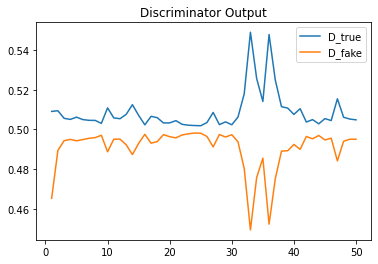

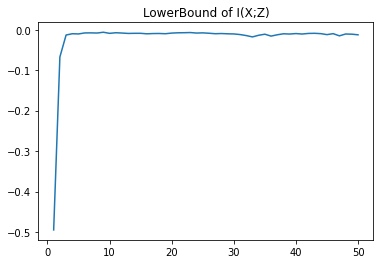

In [215]:
plt.title('Discriminator Output')
plt.plot(np.arange(1, len(D_REAL) + 1), D_REAL, label='D_true')
plt.plot(np.arange(1, len(D_FAKE) + 1), D_FAKE, label='D_fake')
plt.legend()
plt.show()
plt.title('LowerBound of I(X;Z)')
plt.plot(np.arange(1, len(MILBO) + 1), MILBO)
plt.show()

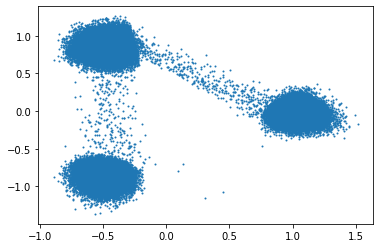

In [216]:
num_samples = 120000
G_sample = G(torch.cat([Z(num_samples), C(num_samples)], dim=1)).data.numpy()
plt.scatter(G_sample[:, 0], G_sample[:, 1], s= 1)
plt.show()